In [1]:
# need to check bias term
# need to check regularization term
# recurrent connection is all zero 


import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch

In [2]:
size = 400
noise_std = 1e-2
alpha = .1
lr = 1e-3

input_size = 3
output_size = 1


In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(10000)


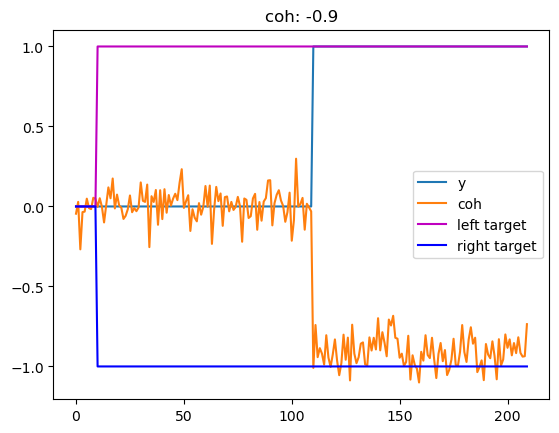

In [4]:
n = 8

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], 'm', label = 'left target')
plt.plot(x_val[n,:,2], 'b', label = 'right target')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()




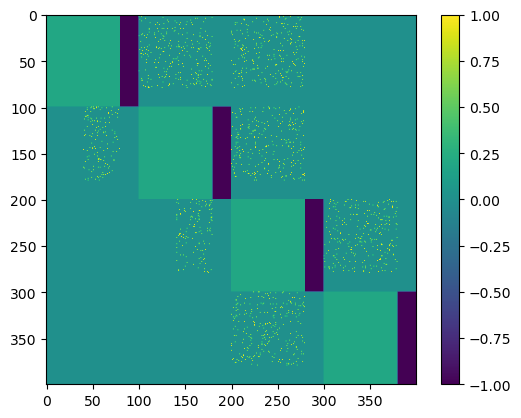

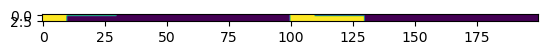

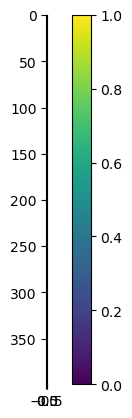

tensor(-25.)


In [69]:
# local connections are sparce
# def create_local_conn(Inum, ratio, n_neurons):

#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = -1
    
#     # Define the size of the matrix
#     rows, cols = n_neurons, n_neurons-Inum
    
#     # Create a zero matrix
#     matrix = torch.zeros(rows, cols)
    
#     # Calculate the number of entries to set to 1
#     num_entries = int(ratio * rows * cols)
    
#     # Randomly select indices
#     indices = torch.randperm(rows * cols)[:num_entries]
    
#     # Set the selected entries to 1
#     matrix.view(-1)[indices] = 1
    
#     mask_rec[:,:n_neurons-Inum] = matrix    

#     return mask_rec

# local connections are continuous 
def create_local_conn(Inum, ratio, n_neurons):

    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = -1
    
    mask_rec[:,:n_neurons-Inum] = ratio    

    return mask_rec



def create_area_conn(Inum, ratio, n_neurons): 
    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = 0
    mask_rec[n_neurons-Inum:,:] = 0
    
    # Define the size of the matrix
    rows, cols = n_neurons-Inum, n_neurons-Inum
    
    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
    
    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
    
    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
    
    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1
    
    mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

    return mask_rec

# # areal connections are continuous 
# def create_area_conn(Inum, ratio, n_neurons): 
#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = 0
#     mask_rec[n_neurons-Inum:,:] = 0
    
    
#     mask_rec[:n_neurons-Inum,:n_neurons-Inum] = ratio

#     return mask_rec



n_neurons = 400
n_inputs = 3
n_outputs = 1


mask_rec = torch.zeros(n_neurons, n_neurons)
mask_in = torch.zeros(n_inputs, n_neurons)
mask_out = torch.ones(n_neurons, n_outputs)


mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)
mask_rec[300:400,300:400] = create_local_conn(20,0.2,100)


connStrength = 0.041

# area2 to 1 feedback
mask_rec[:100,100:200] = create_area_conn(20,connStrength,100)
# mask_rec[:100,100:130] = 0



# area1 to 2 feedforward
mask_rec[100:200,0:100] = create_area_conn(20,connStrength,100)
mask_rec[100:200,0:40] = 0


# area3to 2 feedforward
mask_rec[100:200,200:300] = create_area_conn(20,connStrength,100)
# mask_rec[100:130,200:300] = 0

# area2 to 3 feedback
mask_rec[200:300,100:200] = create_area_conn(20,connStrength,100)
mask_rec[200:300,100:140] = 0


# area3 to 4 feedforward
mask_rec[200:300,300:400] = create_area_conn(20,connStrength,100)
# area3 to 4 feedback
mask_rec[300:400,200:300] = create_area_conn(20,connStrength,100)

# area3 to 1 feedback
mask_rec[0:100,200:300] = create_area_conn(20,connStrength,100)
# mask_rec[:30,200:300] = 0





mask_in[0,:30] = 1
mask_in[1:,:10] = 1


mask_in[1:,100:130] = 1
mask_in[0,100:110] = 1

# mask_in[:,:80] = 1


mask_out[:300,:] = 0
mask_out[380:,:] = 0










wi_mask = mask_in
wo_mask = mask_out
wrec_mask = mask_rec.t()

plt.imshow(mask_rec, cmap = 'viridis')
plt.colorbar()
plt.show()

plt.imshow(wi_mask[:,:200])
plt.show()
plt.imshow(wo_mask)
plt.colorbar()
plt.show()


print(torch.sum(wrec_mask))

In [38]:

# # local connections are continuous 
# def create_local_conn(Inum, ratio, n_neurons):

#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = -1
    
#     mask_rec[:,:n_neurons-Inum] = ratio    

#     return mask_rec



# def create_area_conn(Inum, ratio, n_neurons): 
#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = 0
#     mask_rec[n_neurons-Inum:,:] = 0
    
#     # Define the size of the matrix
#     rows, cols = n_neurons-Inum, n_neurons-Inum
    
#     # Create a zero matrix
#     matrix = torch.zeros(rows, cols)
    
#     # Calculate the number of entries to set to 1
#     num_entries = int(ratio * rows * cols)
    
#     # Randomly select indices
#     indices = torch.randperm(rows * cols)[:num_entries]
    
#     # Set the selected entries to 1
#     matrix.view(-1)[indices] = 1
    
#     mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

#     return mask_rec




# n_neurons = 400
# n_inputs = 3
# n_outputs = 1


# mask_rec = torch.zeros(n_neurons, n_neurons)
# mask_in = torch.zeros(n_inputs, n_neurons)
# mask_out = torch.ones(n_neurons, n_outputs)


# mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
# mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
# mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)
# mask_rec[300:400,300:400] = create_local_conn(20,0.2,100)


# connStrength = 0.036


# mask_rec[:100,100:200] = create_area_conn(20,connStrength,100)



# mask_rec[100:200,0:100] = create_area_conn(20,connStrength,100)

# mask_rec[100:200,200:300] = create_area_conn(20,connStrength,100)

# mask_rec[200:300,100:200] = create_area_conn(20,connStrength,100)



# mask_rec[200:300,300:400] = create_area_conn(20,connStrength,100)
# mask_rec[300:400,200:300] = create_area_conn(20,connStrength,100)
# mask_rec[0:100,200:300] = create_area_conn(20,connStrength,100)





# mask_in[0,:40] = 1


# mask_in[1:,100:140] = 1
# mask_in[0,100:110] = 1


# mask_out[:300,:] = 0
# mask_out[380:,:] = 0










# wi_mask = mask_in
# wo_mask = mask_out
# wrec_mask = mask_rec.t()

# plt.imshow(mask_rec, cmap = 'viridis')
# plt.colorbar()
# plt.show()

# plt.imshow(wi_mask[:,:200])
# plt.show()
# plt.imshow(wo_mask[200:])
# plt.colorbar()
# plt.show()


# print(torch.sum(wrec_mask))

In [70]:
temp3 = torch.normal(0,1 / sqrt(size),size = (400,400))

wrec_init = (np.abs(temp3)*wrec_mask) 

torch.sum(wrec_init)

tensor(0.6017)

In [71]:

net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
                  wrec_mask = wrec_mask, wi_mask = wi_mask, wo_mask = wo_mask, 
                 b_init = None, add_biases = False)

# after trained, recurrent connectivity are all zero
# after trained, bias term will make test accuracy very low
net.non_linearity = torch.relu
net.out_non_linearity = torch.relu

# net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=50, lr=lr, batch_size=100, 
      mask_gradients = False, keep_best=True, cuda=True, early_stop=0.25, clip_gradient = 1)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)


loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

Training...
initial loss: 1.000
epoch 0:  loss=1.000  (took 14.20 s)
epoch 1:  loss=0.991  (took 13.99 s) *
epoch 2:  loss=0.888  (took 13.87 s) *
epoch 3:  loss=0.792  (took 13.94 s) *
epoch 4:  loss=0.760  (took 13.68 s) *
epoch 5:  loss=0.733  (took 13.46 s) *
epoch 6:  loss=0.708  (took 13.54 s) *
epoch 7:  loss=0.628  (took 13.67 s) *
epoch 8:  loss=0.421  (took 13.72 s) *
epoch 9:  loss=0.366  (took 13.38 s) *
epoch 10:  loss=0.326  (took 13.35 s) *
epoch 11:  loss=0.300  (took 13.38 s) *
epoch 12:  loss=0.291  (took 13.41 s) *
epoch 13:  loss=0.273  (took 13.52 s) *
epoch 14:  loss=0.266  (took 13.66 s) *
epoch 15:  loss=0.250  (took 13.51 s) *
epoch 16:  loss=0.241  (took 13.54 s) *
loss=0.233, acc=1.000


In [8]:
attributes = net.__dict__

In [ ]:
attributes.keys()

In [10]:
attributes['non_linearity']

<function torch._VariableFunctionsClass.relu>

In [11]:
# # or load a RNN


# import sys
# sys.path.append('../')

# from low_rank_rnns.modules_connectivity_fullRank import *
# from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

# from matplotlib import pyplot as plt
# # %matplotlib notebook
# import random
# import numpy as np

# import torch
# size = 400
# noise_std = 1e-2
# alpha = .1
# lr = 1e-3

# input_size = 3
# output_size = 1

# # load a full-rank RNN
# net = FullRankRNN(3, size, 1, noise_std, alpha)
# net.load_state_dict(torch.load(f'../models/4areas3.pt', map_location='cpu'))


# # with torch.no_grad():
# #     net1.wi.copy_(net.w_in_eff)
# #     net1.wo.copy_(net.w_out_eff)
# #     net1.wrec.copy_(net.w_rec_eff)


# x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

# loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')

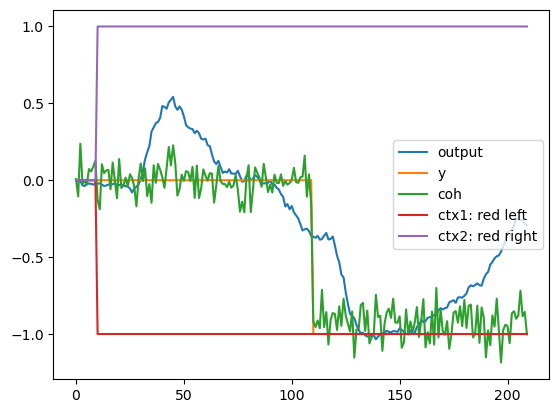

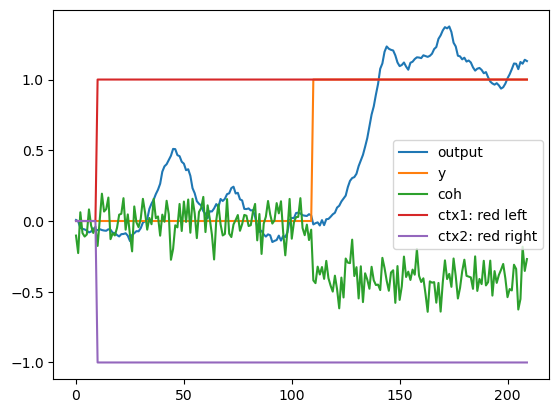

In [72]:
out = out.cpu()
y_val = y_val.cpu()
x_val = x_val.cpu()


for n in range(1, 3):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

In [73]:
traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

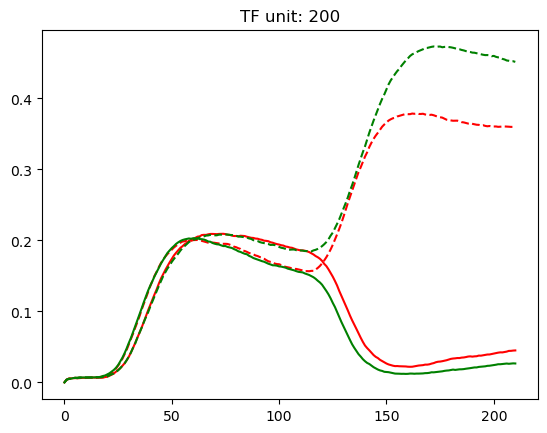

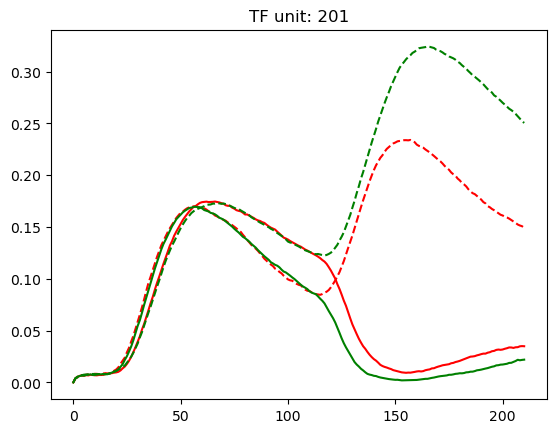

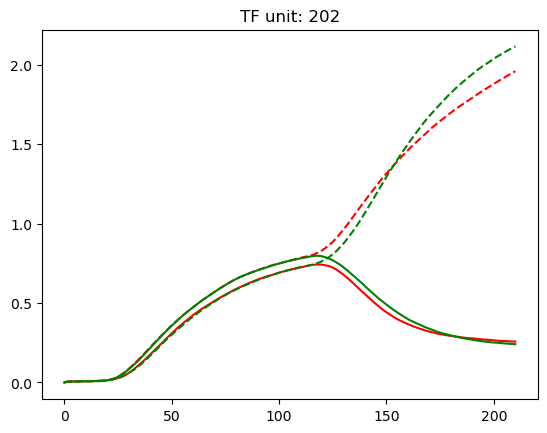

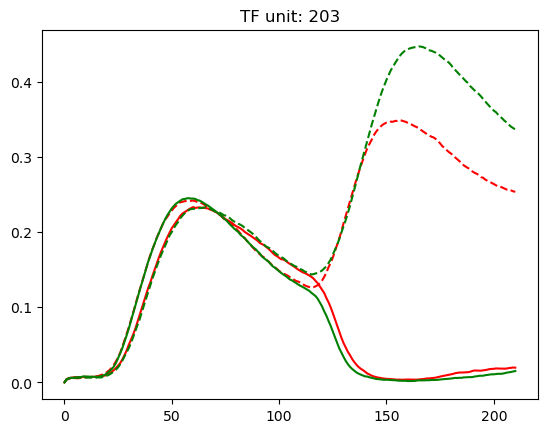

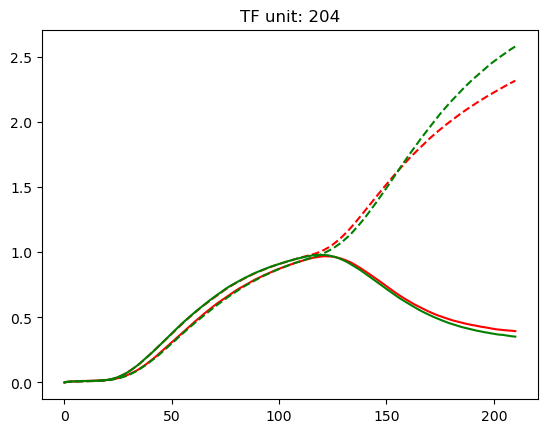

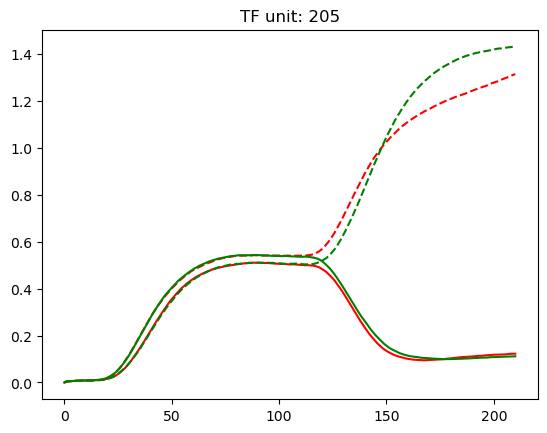

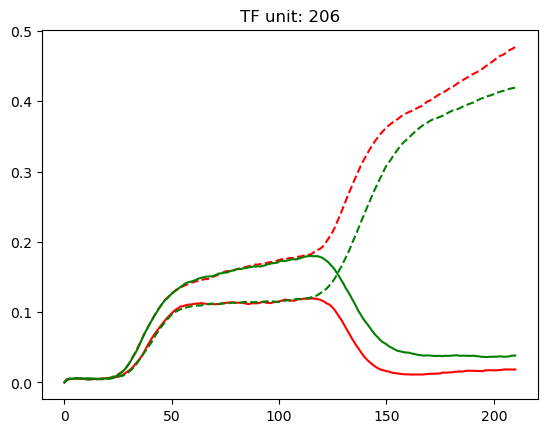

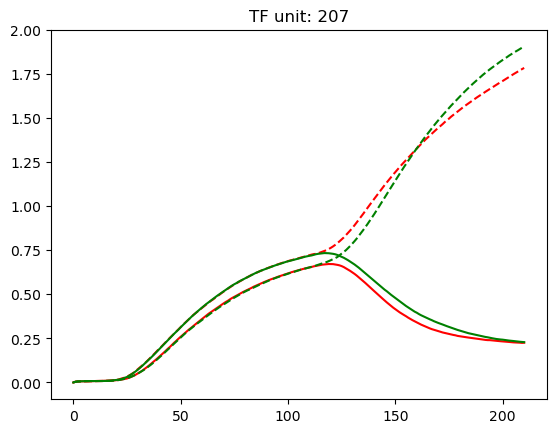

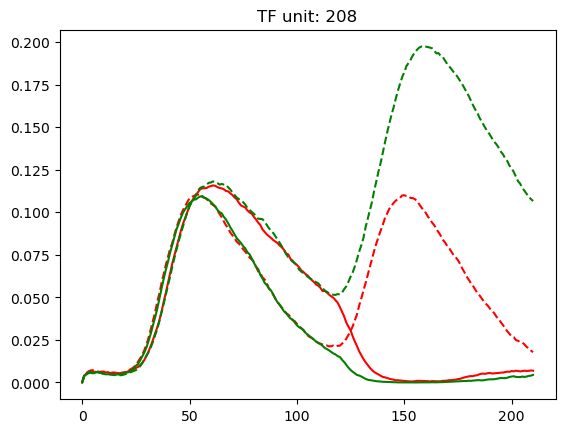

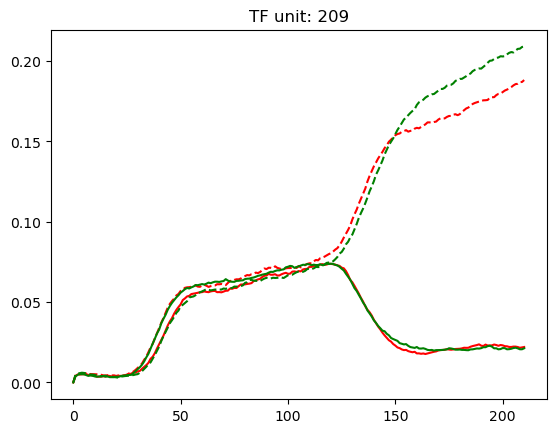

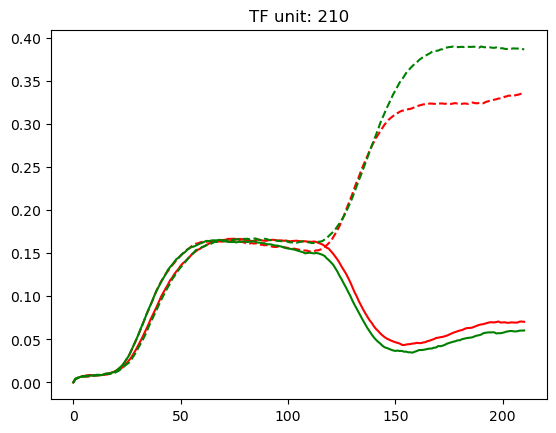

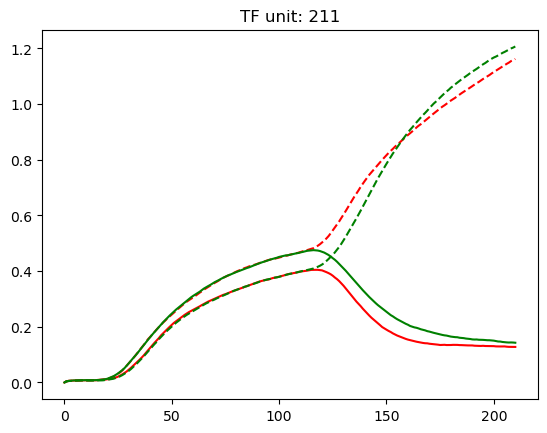

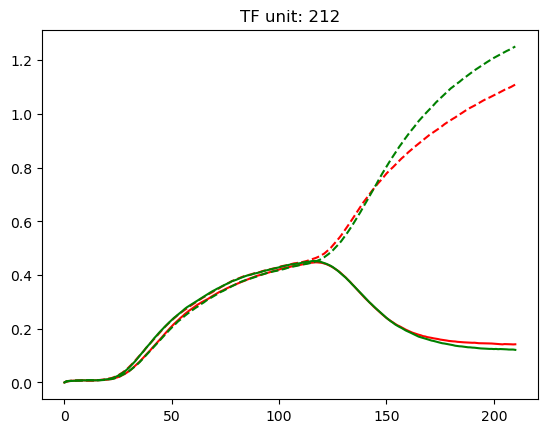

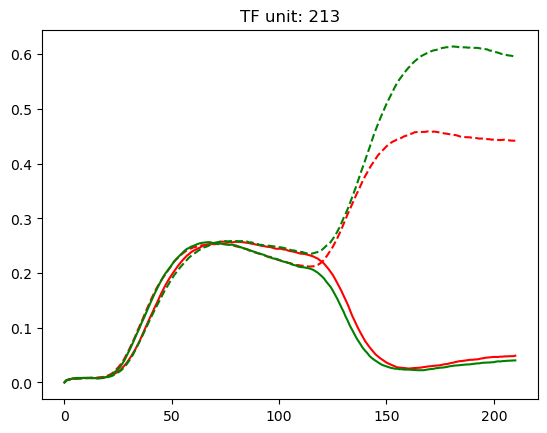

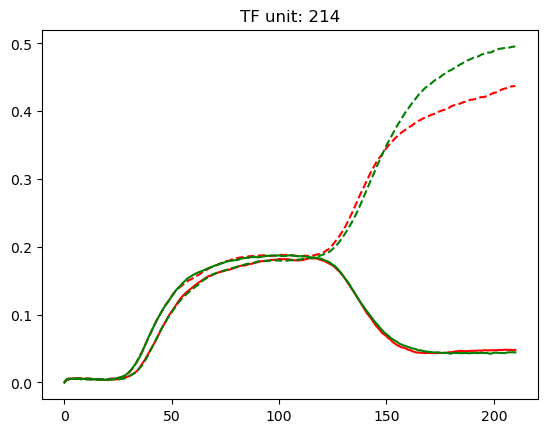

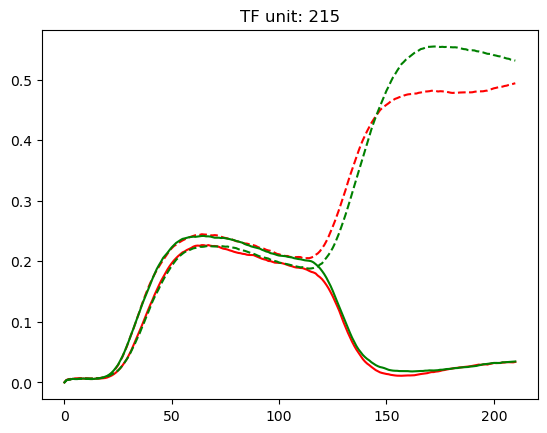

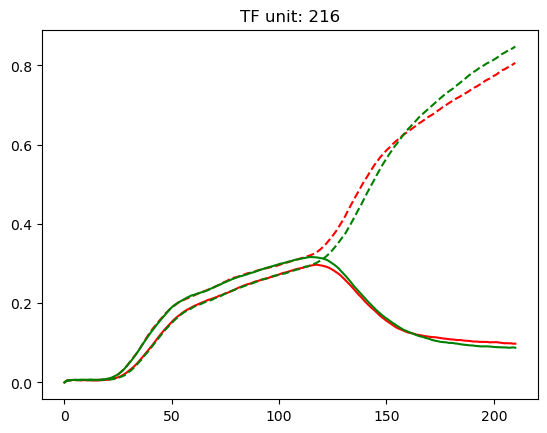

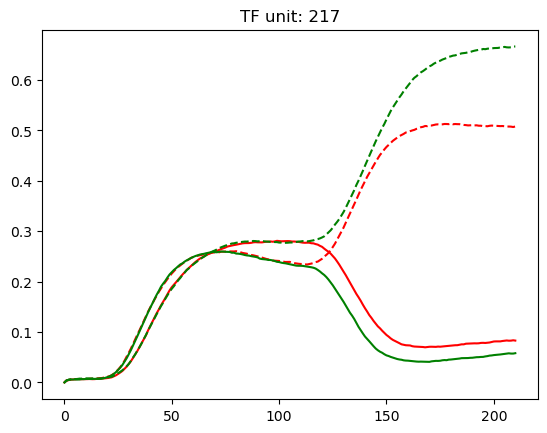

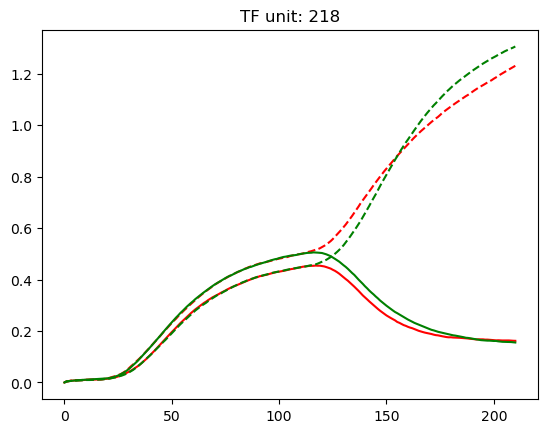

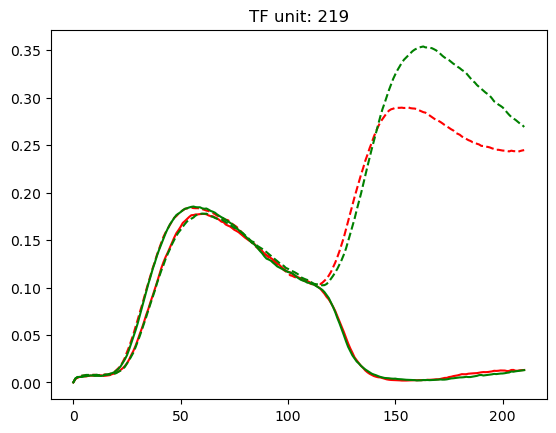

In [75]:
for n in range(200, 220):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

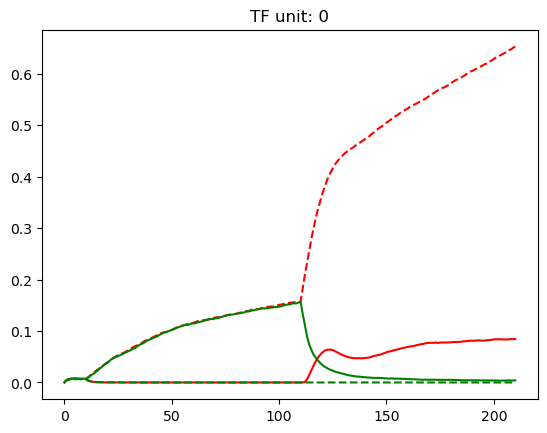

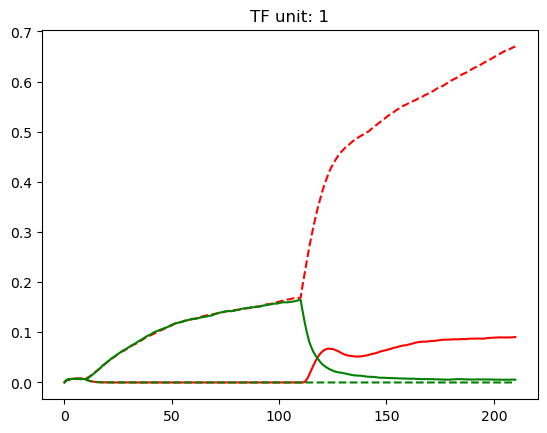

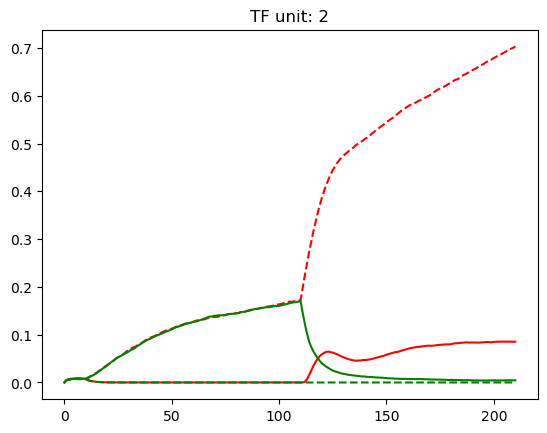

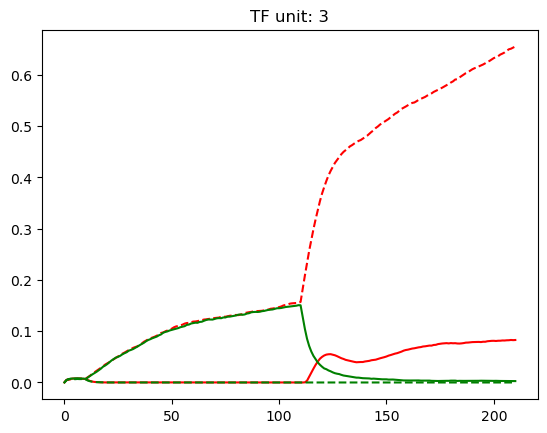

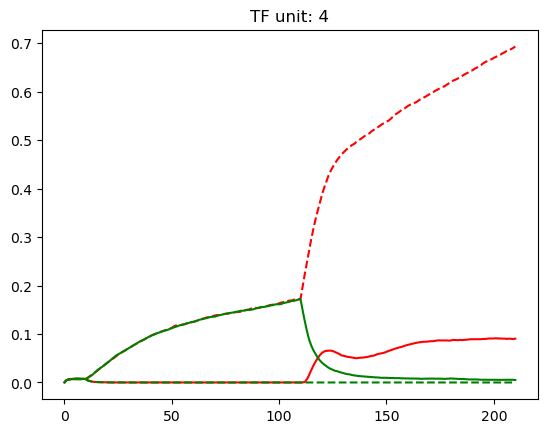

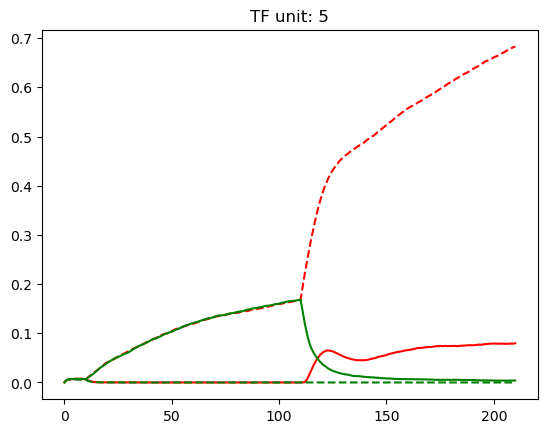

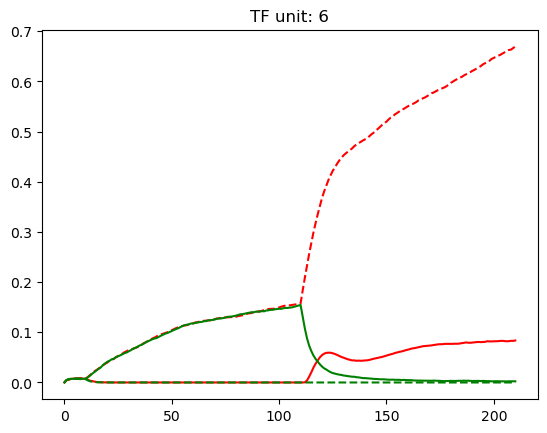

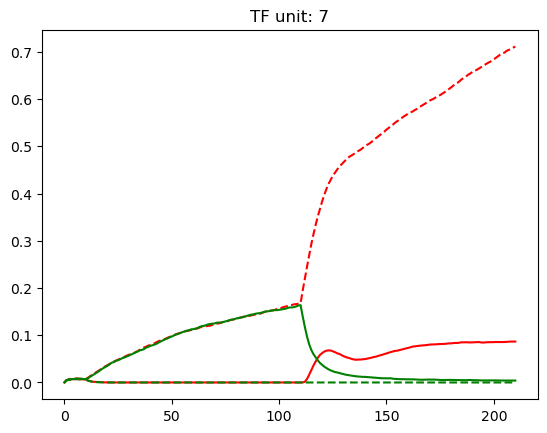

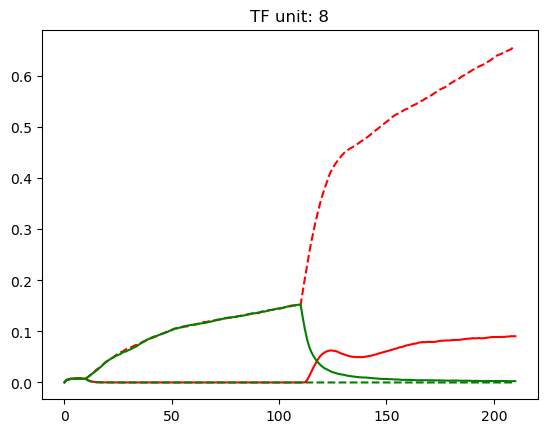

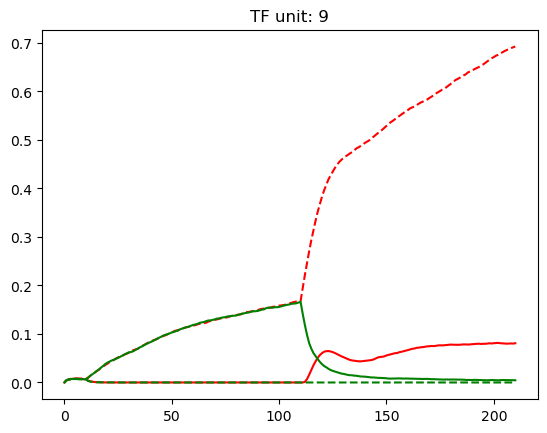

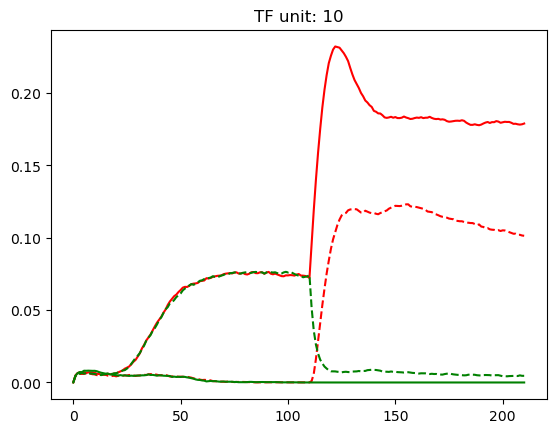

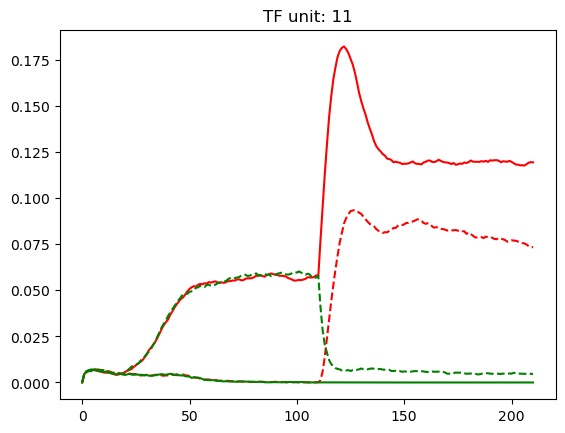

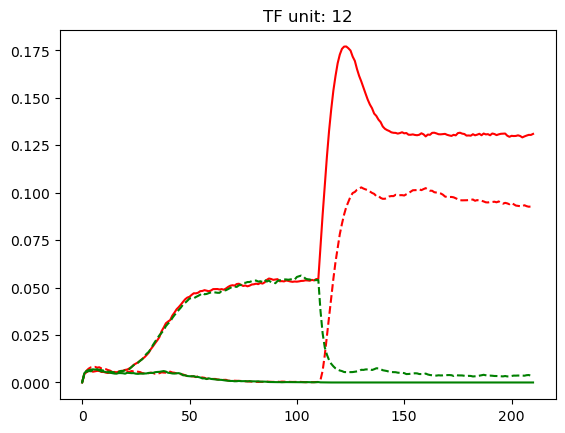

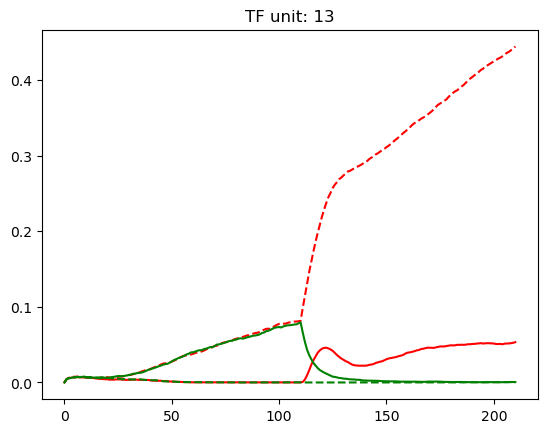

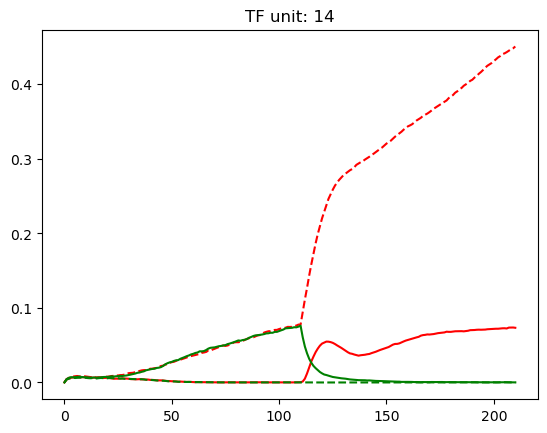

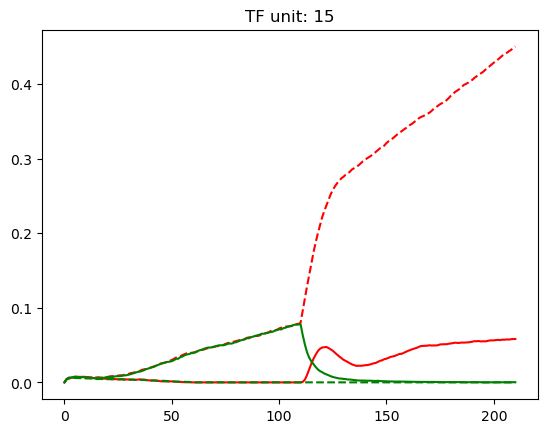

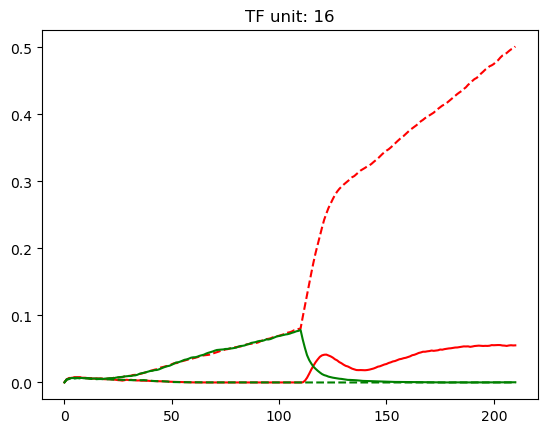

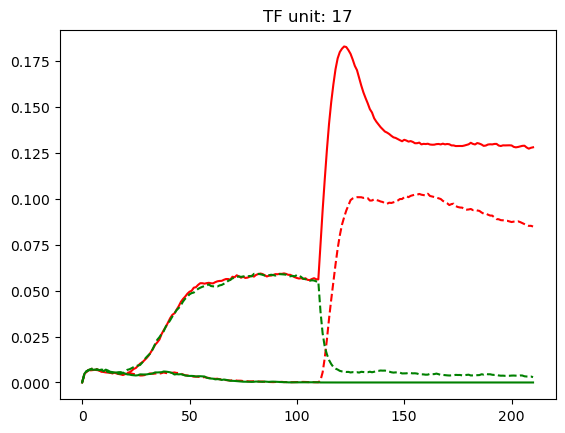

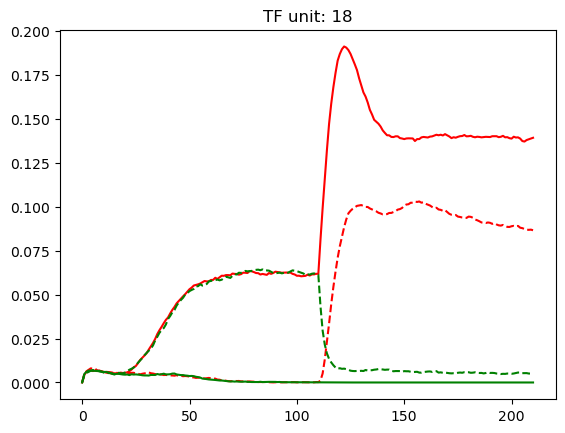

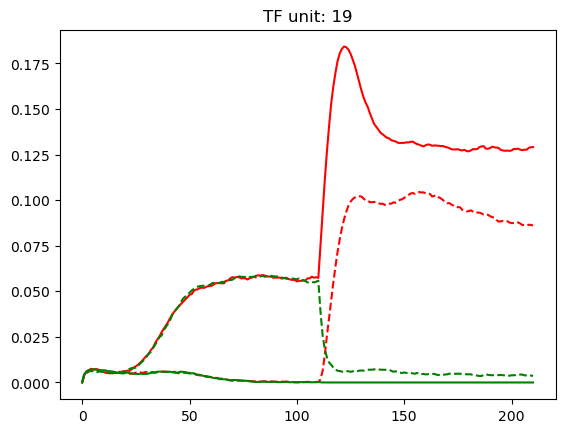

In [78]:
for n in range(00, 20):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

# plot the connectivity matrix


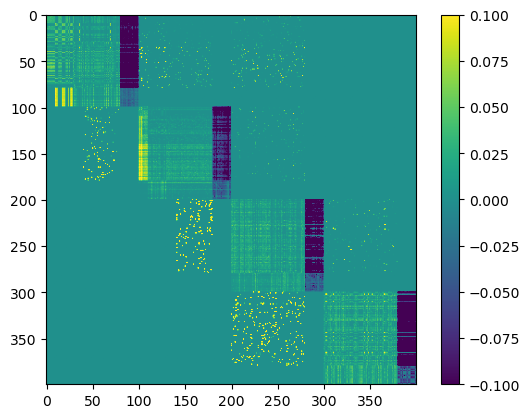

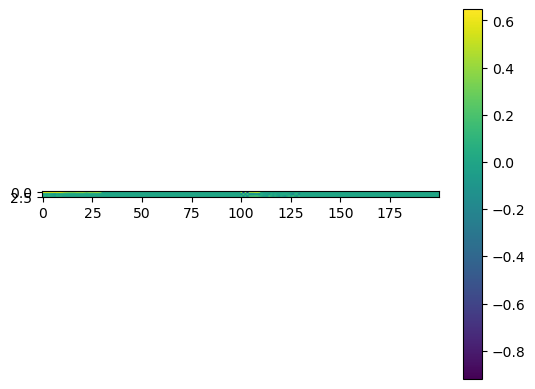

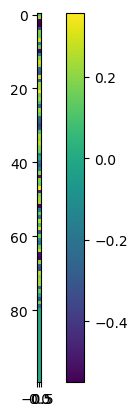

In [79]:
wrec = net.w_rec_eff.cpu()
wi = net.w_in_eff.cpu()
wo = net.w_out_eff.cpu()

a = wrec.detach().numpy()
plt.imshow(np.transpose(a))
plt.colorbar()
plt.set_cmap('viridis')
plt.clim(-0.1, 0.1)
plt.show()

b = wi.detach().numpy()
plt.imshow(b[:,:200])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c[300:])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()


In [25]:
# save the model
torch.save(net.state_dict(), f'../models/4Areas3to1.pt')

In [80]:
trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

In [81]:
a = np.mean(tfRL,axis = 0)
b = np.mean(tfRR,axis = 0)
c = np.mean(tfGL,axis = 0)
d = np.mean(tfGR,axis = 0)

psth = np.concatenate((a,b,c,d), axis=0) # error!
psth.shape

(844, 400)

In [82]:
# # low rank RNN PCA 

# def areaPCA(trajLow):
#     TOn = 10
#     COn = 100
    
#     pca = plot.pca_cumvar(trajLow, n_components=10)
#     plt.ylim(0, 1.02)
#     plt.axhline(1, ls='--', c='gray')
#     plt.show()
    
#     labels = ['RL', 'RR', 'GL', 'GR']
#     colors = ['red', 'red', 'green', 'green']
#     lineStyle = ['-', '--', '-', '--']
    
#     ax1 = pca.components_[0]
#     ax2 = pca.components_[1]
#     ax3 = pca.components_[2]
#     ax4 = pca.components_[3]
    
#     k1 = trajLow @ ax1
#     k2 = trajLow @ ax2
#     k3 = trajLow @ ax3
#     k4 = trajLow @ ax4
    
#     plt.figure()
#     for i in range(4):
#     #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
#         plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
#     plt.show()
    
#     plt.figure()
#     for i in range(4):
#     #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
#         plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
#     plt.show()
    
#     plt.figure()
#     for i in range(4):
#         plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
#     plt.show()
    
#     plt.figure()
#     for i in range(4):
#         plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
#     plt.show()
    
#     # 3D pca plot
#     from mpl_toolkits.mplot3d import Axes3D
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     for i in range(4):
#         plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
#         ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
#                 marker='.', s=400)
#         ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
#                 marker='.', s=400)
#     ax.axis('equal')

# # area 1:
# areaPCA(trajLow[:,:,200:300])
# # area 2:
# # areaPCA(trajLow[:,:,100:200])
# # area 3:
# # areaPCA(trajLow[:,:,200:])

In [24]:

# import sys
# import os


# other_directory_path = os.path.abspath('~/Documents/lowrank_interface/dPCA/python/dPCA/') 

# # Add the directory to sys.path
# sys.path.append(other_directory_path)


import sys
sys.path.append("../dPCA/python/dPCA/")

from numpy import *
from numpy.random import rand, randn, randint
from dPCA import dPCA

In [83]:
area = np.arange(0,400)

dim = trajLow.shape
firingRatesAverage = np.zeros((400,2,2,dim[1]))

firingRatesAverage[:,0,0,:] = (trajLow[0,:,area])
firingRatesAverage[:,0,1,:] = (trajLow[1,:,area])
firingRatesAverage[:,1,0,:] = (trajLow[2,:,area])
firingRatesAverage[:,1,1,:] = (trajLow[3,:,area])


In [84]:
firingRatesAverage.shape

(400, 2, 2, 211)

In [85]:
from scipy.io import savemat
mdic = {"firingRatesAverage": firingRatesAverage}
savemat("../fr/jul29.mat", mdic)


In [31]:
firingRatesAverage.shape

(400, 2, 2, 211)

In [ ]:

# Assuming data is a 4D ndarray with shape (units, stimuli, decisions, time)
# Example dimensions: (units, stimuli, decisions, time)
units, stimuli, decisions, time = firingRatesAverage.shape

# Step 1: Set the dPCA labels (keep dimensions intact)

# Step 2: Apply dPCA directly on the 4D data
dpca_obj = dPCA.dPCA(labels='sdt', regularizer=None)  # Apply dPCA with some regularization
dpca_obj.protect = ['t']  # Protect time marginalization

Z = dpca_obj.fit_transform(firingRatesAverage)  # Perform dPCA

# # Extract results
# W_dpca = dpca.D  # Decoder matrix
# V_dpca = dpca.P  # Encoder matrix  
# whichMarg = dpca.which_marg  # Which marginalization each component belongs to

# print(f"dPCA decoder shape: {W_dpca.shape}")
# print(f"dPCA encoder shape: {V_dpca.shape}")
# print(f"Component marginalization assignment: {whichMarg}")

# # Calculate explained variance
# explVar = dpca.explained_variance_ratio_
# print(f"Explained variance by first 10 components: {explVar[:10]}")


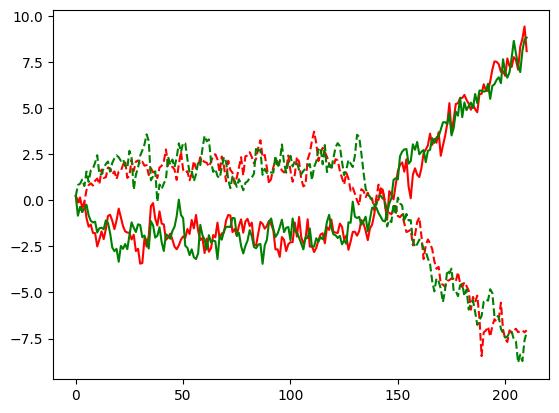

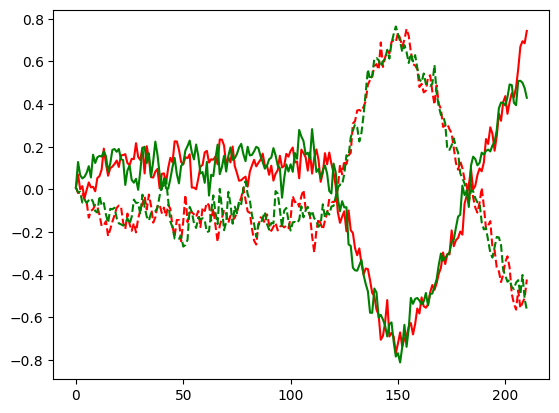

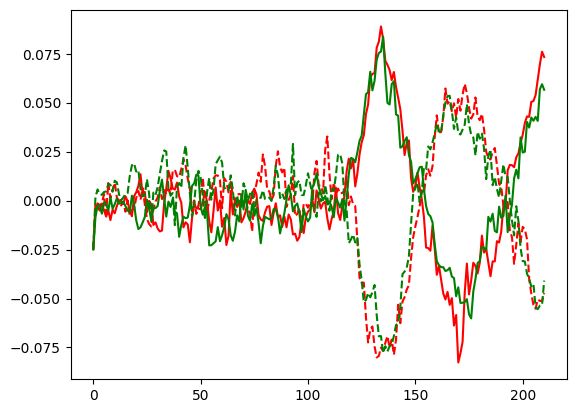

In [70]:
ss = transformed_data['dt']

for ii in range(3):
    plt.plot(ss[ii,0,0,:], 'r-')
    plt.plot(ss[ii,0,1,:], 'r--')
    plt.plot(ss[ii,1,0,:], 'g-')
    plt.plot(ss[ii,1,1,:], 'g--')
    plt.show()

In [26]:

from dPCA import dPCA
# from dPCA.plotting import dpca_plot

def run_dpca_analysis(firingRatesAverage, time=None, num_components=20):
    """
    Run dPCA analysis using the actual dPCA package
    
    Parameters:
    -----------
    firingRatesAverage : ndarray, shape (N, S, D, T)
        Neural firing rates where:
        N = neurons, S = stimulus conditions, D = decision conditions, T = time
    time : array-like, optional
        Time points corresponding to T dimension
    num_components : int
        Number of dPCA components to extract
    
    Returns:
    --------
    dict with dPCA results
    """
    
    print("=== Running dPCA Analysis ===")
    N, S, D, T = firingRatesAverage.shape
    print(f"Data shape: {N} neurons × {S} stimuli × {D} decisions × {T} time points")
    
    # Define parameter grouping (same as MATLAB code)
    # firingRatesAverage array has [N S D T] size
    # Parameters (ignoring neuron dimension):
    #    1 - stimulus 
    #    2 - decision
    #    3 - time
    # Interactions:
    #    [1 3] - stimulus/time interaction
    #    [2 3] - decision/time interaction  
    #    [1 2] - stimulus/decision interaction
    #    [1 2 3] - three-way interaction
    
    combinedParams = [[1, [1, 3]], [2, [2, 3]], [3], [[1, 2], [1, 2, 3]]]
    margNames = ['Stimulus', 'Decision', 'Condition-independent', 'S/D Interaction']
    margColours = np.array([[23, 100, 171], [187, 20, 25], [150, 150, 150], [114, 97, 171]]) / 255
    
    # Time events (e.g., stimulus onset/offset)
    timeEvents = [10, 100]  # Middle time point as example

    
    print(f"Combined parameters: {combinedParams}")
    print(f"Marginalization names: {margNames}")
    
    ## Step 1: Regular PCA of the dataset
    print("\nStep 1: Regular PCA of the dataset")
    
    # Flatten data for regular PCA
    X = firingRatesAverage.reshape(N, -1)  # Shape: (N, S*D*T)
    X_centered = X - np.mean(X, axis=1, keepdims=True)
    
    # SVD for PCA
    U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
    W_pca = U[:, :num_components]  # PCA components
    
    print(f"PCA components shape: {W_pca.shape}")
    
    # You can plot regular PCA results using dpca_plot if available
    # dpca_plot(firingRatesAverage, W_pca, W_pca, 
    #           time=time, timeEvents=timeEvents,
    #           marginalizationNames=['PCA'], 
    #           marginalizationColours=[[0, 0, 0]])
    
    ## Step 2: PCA in each marginalization separately  
    print("\nStep 2: PCA in each marginalization separately")
    
    # This would use dpca_perMarginalization from the package
    # dpca_perMarginalization(firingRatesAverage, combinedParams=combinedParams)
    
    ## Step 3: dPCA without regularization
    print("\nStep 3: dPCA without regularization and ignoring noise covariance")
    
    # Initialize dPCA object
    dpca = dPCA.dPCA(labels='sdt', regularizer=None)
    dpca.protect = ['t']  # Protect time marginalization
    
    # Prepare data - dPCA expects different format
    # Convert from (N, S, D, T) to the format expected by dPCA
    
    # Option 1: If dPCA expects (N, S, D, T, trials) format
    # Add a trials dimension (assuming trial-averaged data)
    firingRates_with_trials = firingRatesAverage[..., np.newaxis]  # Shape: (N, S, D, T, 1)
    
    # Create trial numbers array (all conditions have 1 trial since data is averaged)
    trialNum = np.ones((S, D), dtype=int)
    
    try:
        # Fit dPCA
        print("Fitting dPCA...")
        Z = dpca.fit_transform(firingRates_with_trials, trialNum)
        
        # Extract results
        W_dpca = dpca.D  # Decoder matrix
        V_dpca = dpca.P  # Encoder matrix  
        whichMarg = dpca.which_marg  # Which marginalization each component belongs to
        
        print(f"dPCA decoder shape: {W_dpca.shape}")
        print(f"dPCA encoder shape: {V_dpca.shape}")
        print(f"Component marginalization assignment: {whichMarg}")
        
        # Calculate explained variance
        explVar = dpca.explained_variance_ratio_
        print(f"Explained variance by first 10 components: {explVar[:10]}")
        
        # # Plot dPCA results using the package's plotting function
        # dpca_plot(firingRatesAverage, W_dpca, V_dpca,
        #           explainedVar=explVar,
        #           marginalizationNames=margNames,
        #           marginalizationColours=margColours,
        #           whichMarg=whichMarg,
        #           time=time,
        #           timeEvents=timeEvents,
        #           timeMarginalization=2,  # Time is 3rd parameter (0-indexed as 2)
        #           legendSubplot=True)
        
        results = {
            'W_pca': W_pca,
            'W_dpca': W_dpca, 
            'V_dpca': V_dpca,
            'whichMarg': whichMarg,
            'explVar': explVar,
            'Z': Z,
            'dpca_object': dpca,
            'combinedParams': combinedParams,
            'margNames': margNames,
            'margColours': margColours
        }
        
        return results
        
    except Exception as e:
        print(f"Error running dPCA: {e}")
        print("This might be due to data format issues or missing dependencies.")
        print("Please check that:")
        print("1. The dPCA package is properly installed")
        print("2. Your data format matches what dPCA expects")
        print("3. All required dependencies are available")
        
        # Return PCA results as fallback
        return {
            'W_pca': W_pca,
            'W_dpca': None,
            'V_dpca': None, 
            'whichMarg': None,
            'explVar': None,
            'Z': None,
            'dpca_object': None,
            'combinedParams': combinedParams,
            'margNames': margNames,
            'margColours': margColours,
            'error': str(e)
        }

def plot_dpca_components(firingRatesAverage, W_dpca, whichMarg=None, 
                        margNames=None, margColours=None, time=None, 
                        num_components=6):
    """
    Plot dPCA components using the decoder matrix from the dPCA package
    
    Parameters:
    -----------
    firingRatesAverage : ndarray, shape (N, S, D, T)
        Original neural data
    W_dpca : ndarray, shape (N, n_components)
        dPCA decoder matrix from the package
    whichMarg : array-like
        Marginalization assignment for each component
    margNames : list
        Names of marginalizations
    margColours : ndarray
        Colors for each marginalization
    time : array-like
        Time points
    num_components : int
        Number of components to plot
    """
    
    if W_dpca is None:
        print("No dPCA results to plot")
        return
    
    N, S, D, T = firingRatesAverage.shape
    n_components = min(W_dpca.shape[1], num_components)
    
    # Default values
    if margNames is None:
        margNames = ['Stimulus', 'Decision', 'Time', 'Interaction']
    if margColours is None:
        margColours = np.array([[23, 100, 171], [187, 20, 25], 
                               [150, 150, 150], [114, 97, 171]]) / 255
    if time is None:
        time = np.arange(T)
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # Project data onto dPCA components
    for comp_idx in range(n_components):
        ax = axes[comp_idx]
        
        # Get component weights
        component_weights = W_dpca[:, comp_idx]
        
        # Project each condition onto this component
        for s in range(S):
            for d in range(D):
                # Get neural activity for this condition
                neural_activity = firingRatesAverage[:, s, d, :]  # Shape: (N, T)
                
                # Project onto component
                component_activity = component_weights @ neural_activity  # Shape: (T,)
                
                # Determine line style and color
                linestyle = '-' if d == 0 else '--'
                color_idx = s if whichMarg is None else int(whichMarg[comp_idx]) % len(margColours)
                color = margColours[color_idx]
                
                # Plot
                label = f'S{s+1}D{d+1}' if comp_idx == 0 else ""
                ax.plot(time, component_activity, 
                       label=label, linestyle=linestyle, 
                       color=color, alpha=0.8, linewidth=2)
        
        # Formatting
        title = f'dPC {comp_idx+1}'
        if whichMarg is not None and comp_idx < len(whichMarg):
            marg_idx = int(whichMarg[comp_idx]) % len(margNames)
            title += f' ({margNames[marg_idx]})'
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Time')
        ax.set_ylabel('Component Activity')
        ax.grid(True, alpha=0.3)
        
        if comp_idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Hide unused subplots
    for i in range(n_components, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('dPCA Components Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [27]:
time = np.arange(0,211,211)
results = run_dpca_analysis(firingRatesAverage, time)

=== Running dPCA Analysis ===
Data shape: 100 neurons × 2 stimuli × 2 decisions × 211 time points
Combined parameters: [[1, [1, 3]], [2, [2, 3]], [3], [[1, 2], [1, 2, 3]]]
Marginalization names: ['Stimulus', 'Decision', 'Condition-independent', 'S/D Interaction']

Step 1: Regular PCA of the dataset
PCA components shape: (100, 20)

Step 2: PCA in each marginalization separately

Step 3: dPCA without regularization and ignoring noise covariance
Fitting dPCA...
Error running dPCA: operands could not be broadcast together with shapes (100,2,2,211,1) (100,1,1,1) 
This might be due to data format issues or missing dependencies.
Please check that:
1. The dPCA package is properly installed
2. Your data format matches what dPCA expects
3. All required dependencies are available


In [28]:
results

{'W_pca': array([[-7.31165565e-02,  1.25519907e-01, -5.84003925e-02, ...,
          9.31240768e-02,  1.04810295e-01, -1.32432317e-01],
        [-1.85086854e-01, -1.18643695e-01,  7.96714723e-02, ...,
          1.05717311e-02,  7.41696080e-02, -4.54943246e-02],
        [-3.50394242e-03,  5.57306986e-02, -4.72168271e-02, ...,
          2.12206708e-01, -5.52180278e-03, -8.42702031e-02],
        ...,
        [-3.21142978e-02, -1.12752042e-02, -7.62452694e-03, ...,
         -1.20359237e-01,  3.90554283e-02, -3.77541480e-02],
        [-2.72711785e-02, -4.07562169e-03, -8.67608208e-03, ...,
          1.03096347e-01, -5.51708288e-02, -1.87723373e-02],
        [ 1.19673699e-04,  8.22107618e-03, -1.86621733e-03, ...,
          8.93072739e-02, -3.95856177e-02,  5.50124439e-02]]),
 'W_dpca': None,
 'V_dpca': None,
 'whichMarg': None,
 'explVar': None,
 'Z': None,
 'dpca_object': None,
 'combinedParams': [[1, [1, 3]], [2, [2, 3]], [3], [[1, 2], [1, 2, 3]]],
 'margNames': ['Stimulus',
  'Decision',
